In [1]:
import torch
from tqdm import tqdm

In [2]:
# dataset is a shakespeare text in input.txt
# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

def get_data():
    # data will be some text with characters and some newlines, roughly 1.1 million characters
    with open('input.txt', 'r', encoding='utf-8') as f:
        data = f.read()
    return data

In [3]:
text = get_data()
#['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A',
#'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 
#'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c',
#'d', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 
#'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = { ch: i for i, ch in enumerate(chars)}
itos = { i: ch for i, ch in enumerate(chars)}
# for a string give a list of integers for each character in it
encode = lambda s: [stoi[ch] for ch in s]
# do the opposite
decode = lambda li: [itos[i] for i in li]

# convert all text into numbers
data = torch.tensor(encode(text), dtype=torch.long)
print(f"Data shape: {data.shape}, dtype: {data.dtype}")


Data shape: torch.Size([1115394]), dtype: torch.int64


### Split data

In [4]:
n = int(0.9 * len(data))
train_data= data[:n]
val_data = data[n:]

In [5]:
len(train_data), len(val_data)

(1003854, 111540)

In [6]:
context_length = 8 # I like context length more than block size


In [7]:
x= train_data[:context_length]
y = train_data[1:context_length+1]
for t in range(context_length):
    context = x[:t+1]
    target = y[t]
    print(f"Input: {context}, target: {target}")

Input: tensor([18]), target: 47
Input: tensor([18, 47]), target: 56
Input: tensor([18, 47, 56]), target: 57
Input: tensor([18, 47, 56, 57]), target: 58
Input: tensor([18, 47, 56, 57, 58]), target: 1
Input: tensor([18, 47, 56, 57, 58,  1]), target: 15
Input: tensor([18, 47, 56, 57, 58,  1, 15]), target: 47
Input: tensor([18, 47, 56, 57, 58,  1, 15, 47]), target: 58


In [8]:
torch.manual_seed(1337)

In [9]:
batch_size = 4
context_length = 8

def get_batch(split):
    data = train_data if split == 'train' else val_data
    # generate (batch_size,) indices that are in [0, len(data) - context_length]
    ix = torch.randint(len(data) - context_length, (batch_size,))
    # each ix gives one context in the batch
    x = torch.stack([data[i:i+context_length] for i in ix])
    y = torch.stack([data[i+1:i+context_length+1] for i in ix])
    return x, y

In [10]:
xb, yb = get_batch('train')

In [11]:
print(xb.shape, yb.shape)

torch.Size([4, 8]) torch.Size([4, 8])


In [12]:
print(f"Inputs: {xb}")

Inputs: tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])


In [13]:
print(f"Targets: {yb}")

Targets: tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])


In [14]:
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(1337)

In [15]:
# basically given the current character, learn
# a probability distribution over the next characters.
# when you get new characters, lookup in the table to see what could come next
class BigramModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, inputs, targets=None):
        # get the logits 
        # # (Batch_size x Context length x (vocab_size/embedding dimension)
        logits = self.token_embedding_table(inputs)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            # target are just indices of the next character.
            # In some sense T is just doing more complex batching
            # You could just unroll this to (BT, 1) input -> (BT, C) logits
            # and (BT) as target
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
            
        return logits, loss

    def generate(self, inputs, max_new_tokens):
        # inputs is (B x context_length) and keeps increasing as you generate
        # probably this doesn't matter
        for _ in range(max_new_tokens):
            #print(inputs.shape)
            logits, loss = self(inputs)
            #print(logits.shape)
            # logits the last value will have the next token 
            # it is a bit moot to call is context, but we will expand on it 
            # i guess, with attention
            # get the prob dist of the last input in each batch
            logits = logits[:, -1, :]
            # apply softmax to get probabilits
            probs = F.softmax(logits, dim=-1) # still B x vocab_size
            # sample from the distribution to get the next character
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)%

            # append to th input
            inputs = torch.cat((inputs, idx_next), dim=1) # (B, context_length + 1)
        return inputs

In [16]:
model = BigramModel(vocab_size)

In [17]:
logits, loss = model(xb, yb)

In [18]:
loss

tensor(4.8786, grad_fn=<NllLossBackward0>)

In [19]:
new_input = model.generate(xb, max_new_tokens=10)

In [20]:
xb.shape

torch.Size([4, 8])

In [21]:
new_input.shape

torch.Size([4, 18])

In [22]:
print(''.join(decode(model.generate(inputs = torch.ones((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist())))


 EHN&jLDJgOLVz'RIoDqHdhsV&vLLxatjscMpwLERSPyao.qfzs$Ys$zF-w,;eEkzxjgCKFChs!iWW.ObzDnxA Ms$3!dcbf?pGXe


In [23]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [24]:
batch_size = 1024
losses =[]
for steps in tqdm(range(10000)):
    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
print(loss.item())


100%|█████████████████████████████████████| 10000/10000 [04:05<00:00, 40.81it/s]

2.4484620094299316


In [25]:
print(''.join(decode(model.generate(inputs = 55*torch.ones((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist())))

qucort
BRI t veratle, s h;

Sie elor orsty.
M:
SAMathe 'd twanon'lctreatere f sly deed
Jup rand, at b


In [26]:
import matplotlib.pyplot as plt

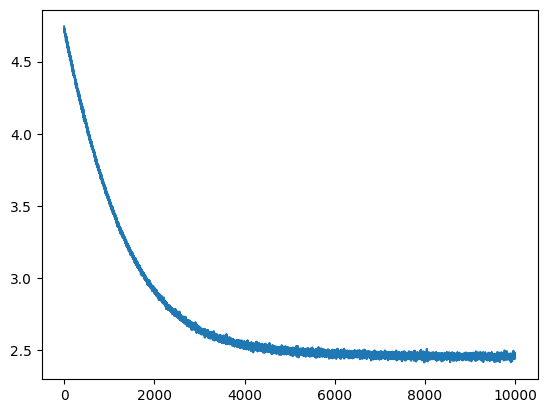

In [27]:
plt.plot(losses)

In [28]:
print(''.join(decode(model.generate(inputs = torch.ones((1, 1), dtype=torch.long), max_new_tokens=500)[0].tolist())))


 oCERE: outhit toreeyirille hothoran'll and f
Ordans ?
WAMer ssme possad on!'lllofonoousid, ullenthe;
TISl cthilan hiut 'e r'dan Evendangboth nt:
PEO: o het atw,
plf hanofoonthavelouprllfitrdld t yo met mplok, we wostthee, t
Dise s t frh corthenas; ERIUS halicathil,
Te ngindicaght ule stis
The ous at d nddicthal yom wathilind ar hetht, situs yldave

O:

IUngid y, ho davew alot w re t m my,
Tomar:
A: ut l ont.
Marcay by the witipo caide nas,
NGot
AntNCak; T:


D:

WAwouet'dr her,
I sofr thesor Me 


##### attention module

In [50]:
torch.manual_seed(1335)
B, T, C = 4, 8, 2
x = torch.randn(B, T, C)

In [51]:
### mean of the previous elements
xbow = torch.zeros((B,T,C))
for b in range(B):
    for t in range(T):
        xprev = x[b, :t+1]
        xbow[b, t] = torch.mean(xprev, 0)


In [52]:
weights = torch.tril(torch.ones(T,T))
weights = weights/ weights.sum(1, keepdim=True)
xbow2 = weights @ x # (1, T, T) @ (B, T, C) ---> (B, T, C)
torch.allclose(xbow, xbow2, )#atol=1e-5)

True

In [59]:
weights = torch.zeros((T, T))
tril = torch.tril(torch.ones(T,T))
weights = weights.masked_fill(tril == 0, float('-inf'))
weights = F.softmax(weights, dim=-1)
xbow3 = weights @ x

In [60]:
torch.allclose(xbow, xbow3)

True

In [119]:
## self attention
torch.manual_seed(1337)
B, T, C = 4, 8, 32
x = torch.randn(B, T, C)


# single head attention
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x) # (B, T, head_size)
q = query(x) # (B, T, head_size)
weights = q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) -> (B, T, T)

tril = torch.tril(torch.ones(T, T))
#weights = torch.zeros((T, T))
weights = weights.masked_fill(tril == 0, float('-inf'))
weights = F.softmax(weights, dim=-1)
v = value(x)
out = weights @ v
#out.shape

In [120]:
out.shape

torch.Size([4, 8, 16])

In [179]:
class SelfAttentionHead(nn.Module):

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embed, head_size, bias=False)
        self.query = nn.Linear(n_embed, head_size, bias=False)
        self.value = nn.Linear(n_embed, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x) # (B, T, head_size)
        q = self.query(x) # (B, T, head_size)

        wei = q @ k.transpose(-2, -1) * C**-0.5 # (B, T, C) @ (B, C, T) --> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)

        v = self.value(x) # (B, T, C)
        out = wei @ v
        return out

In [180]:
class MultiHeadSelfAttention(nn.Module):

        def __init__(self, num_heads, head_size):
            super().__init__()
            self.heads = nn.ModuleList([SelfAttentionHead(head_size) for _ in range(num_heads)])
            self.proj = nn.Linear(n_embed, n_embed)
        def forward(self, x):
            out =  torch.cat([h(x) for h in self.heads], dim=-1)
            out = self.proj(out)
            return out

In [181]:
class FeedFoward(nn.Module):

    def __init__(self, n_embed):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(n_embed, 4 * n_embed),
                                 nn.ReLU(),
                                 nn.Linear(4 * n_embed, n_embed)
                                )
    def forward(self, x):
        return self.net(x)

In [182]:
class Block(nn.Module):

    def __init__(self, n_embed, n_head):
        super().__init__()
        head_size = n_embed // n_head
        self.sa = MultiHeadSelfAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embed)
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)
    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [183]:
class AttentionLM(nn.Module):

    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
        self.position_embedding_table = nn.Embedding(block_size, n_embed)
        self.blocks = nn.Sequential(
            Block(n_embed, n_head=4),
            Block(n_embed, n_head=4),
            Block(n_embed, n_head=4),
            nn.LayerNorm(n_embed),
        )

        self.lm_head = nn.Linear(n_embed, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        token_embedding = self.token_embedding_table(idx) # (B, T, n_embed)
        pos_embedding = self.position_embedding_table(torch.arange(T, device=device)) # (1, T, n_embed)
        x = token_embedding + pos_embedding # --> (B, T, n_embed)
        x = self.blocks(x)
        logits = self.lm_head(x) # (B, T, vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array with indices into vocab
        for _ in range(max_new_tokens):

            idx_con = idx[:, -block_size:]
            logits, loss = self(idx_con)
            # only the last time step
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            idx = torch.cat([idx, idx_next], dim=-1)
        return idx

In [191]:
n_embed = 32
block_size= 8
batch_size = 32
learning_rate = 3e-4
device='cuda:0'
model = AttentionLM()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [192]:
model.to(device)
losses =[]
for steps in tqdm(range(10000)):
    # sample a batch of data
    xb, yb = get_batch('train')
    xb, yb = xb.to(device), yb.to(device)

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
print(loss.item())


100%|█████████████████████████████████████| 10000/10000 [02:20<00:00, 71.07it/s]

2.0549874305725098


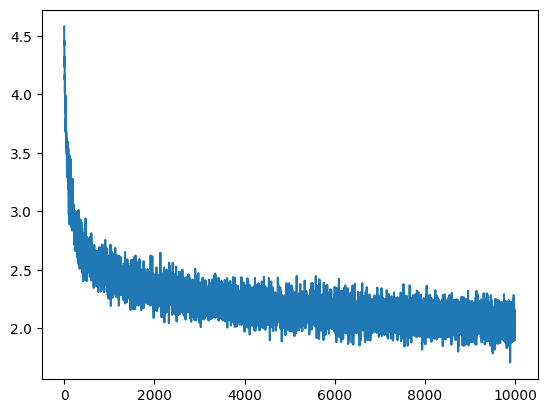

In [193]:
plt.plot(losses)

In [194]:
print(''.join(decode(model.generate(idx = torch.ones((1, 1), dtype=torch.long, device=device), max_new_tokens=500)[0].cpu().tolist())))


 shall the but thinfes fortews, my farset,
I knaing where of inst bo knig are theirss:
Welle shalal:
Seare willaiguy vill to groth Rike?
Now, VI play; thery haich a aha roodink
Feres mon Worigln, thes is a bofore mele porym, with The you shal: gied in them?
For hup ance you, sarss niver the this taze not thest lorg! how mever it bries.

DCOLARD:
In pattenroh shel, dowatwe your meere cinturaungce?

KAHIMIN:
You, no planesen that fileathou apo, to do gencarce a mxplitining then old buse, donate the
